    """
    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
    Reward:
        Reward is 1 for every step taken, including the termination step
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.
    """

In [1]:
import os,sys
curr_path = os.getcwd()
# utils_dir = '/home/devel/learning/easy-rl-master/codes'
# sys.path.insert(0, utils_dir) 
sys.path.append('../../codes')
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
import datetime
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # obtain current time

import torch
from itertools import count
import gym
from agent import Agent
from common.plot import plot_rewards
from common.utils import save_results,make_dir

In [2]:
class PG_config:
    def __init__(self,agent='Reinforce',env='CartPole-v0'):
        self.agent = agent     # name of agent
        self.env = env
        self.result_path = curr_path+"/outputs/" +self.env+'/'+curr_time+'/'+agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env+'/'+curr_time+'/'+agent+'/models/'  # path to save models
        self.train_eps = 400 # number of training episode
        self.eval_eps = 100   # number of evaluation episode
        self.batch_size = 8  # number of batch
        self.lr = 0.01       # learning rate
        self.gamma = 0.99    # discount rate of reward
        self.model = 'MLP'
        self.hidden_dim = 36 # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

In [3]:
def init_env_agent(cfg,seed=1):
    ### initial environment ### 
    env = gym.make(cfg.env)  
    env.seed(seed)
    
    ### initial agent ### 
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = Agent(state_dim,action_dim,cfg)
    return env,agent

In [4]:
def try_env():
    env = gym.make("CartPole-v0")

    actions = ['Left','Right']
#     actions_arrow = ['↑','→','↓','←']

    obs = env.reset()  # 重置一个 episode
    for i in range(100):
        print('ROUND',i)
        env.render()  # 显示图形界面
        print('\nFROM',obs)
        action = env.action_space.sample() # 从动作空间中随机选取一个动作
        print(actions[action])
        obs, reward, done , _ = env.step(action) # 用于提交动作，括号内是具体的动作
        print('END',obs)
        print('-'*10)
    env.close() # 关闭环境

In [5]:
# try_env()

In [6]:
# import gym
# from IPython import display
# import matplotlib
# import matplotlib.pyplot as plt
# %matplotlib inline

# # env = gym.make('MountainCar-v0')
# env = gym.make('CartPole-v0')
# env.reset()
# img = plt.imshow(env.render(mode='rgb_array')) # only call this once
# for _ in range(100):
#     img.set_data(env.render(mode='rgb_array')) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     action = env.action_space.sample()
#     env.step(action)

In [7]:
def train(cfg,env,agent):
    batch_state, batch_action, batch_reward = [],[],[]
    rewards, ma_rewards = [], []
    
    for i_eps in range(cfg.train_eps):
        state = env.reset()
        eps_reward = 0
        ### run until done ###
        for i in count():
            action = agent.sample(state)
            next_state,reward,done,_ = env.step(action)
            eps_reward += reward
            
            batch_state.append(state)
            batch_action.append(action)
            batch_reward.append(reward)
            state = next_state
            if done:
                if eps_reward < 200: # dead to restart
                    batch_reward[-1] = 0
                break
        ### update agent by batch ### 
        if i_eps > 0 and i_eps % cfg.batch_size == 0:
            agent.learn(batch_state,batch_action,batch_reward)
            batch_state, batch_action, batch_reward = [],[],[]
        ### recording for each episode ###
        rewards.append(eps_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+eps_reward*0.1)
        else:
            ma_rewards.append(eps_reward)
        if (i_eps+1)%10==0:
            print(f"Episode:{i_eps+1}/{cfg.train_eps}: reward:{eps_reward:.1f}")       
    return ma_rewards, rewards

In [8]:
def evaluate(cfg,env,agent,render=False):
    rewards, ma_rewards = [], []
    for i_eps in range(cfg.eval_eps):
        state = env.reset()
        eps_reward = 0
        done = False
        while not done:
            if render:
                env.render()  
            action = agent.predict(state)
            next_state,reward,done,_ = env.step(action)
            eps_reward += reward
            state = next_state

        rewards.append(eps_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+eps_reward*0.1)
        else:
            ma_rewards.append(eps_reward)
        if (i_eps+1)%10==0:
            print(f"Episode:{i_eps+1}/{cfg.train_eps}: reward:{eps_reward:.1f}")       
    return ma_rewards, rewards

In [12]:
def main():
#     agent = 'Reinforce_baseline'
    agent = 'Reinforce'
    print(agent)
    cfg = PG_config(agent)
    
    env,agent = init_env_agent(cfg,seed=1)
    ma_rewards,rewards = train(cfg,env,agent)
    make_dir(cfg.result_path,cfg.model_path)
    agent.save(path=cfg.model_path)
    save_results(rewards,ma_rewards,tag='train',path=cfg.result_path)
    plot_rewards(rewards,ma_rewards,tag="train",env=cfg.env,algo = cfg.agent,path=cfg.result_path)

    env,agent = init_env_agent(cfg,seed=10)
    agent.load(path=cfg.model_path)
    ma_rewards,rewards = evaluate(cfg,env,agent,render=False)
    save_results(rewards,ma_rewards,tag='eval',path=cfg.result_path)
    plot_rewards(rewards,ma_rewards,tag="eval",env=cfg.env,algo = cfg.agent,path=cfg.result_path)

Reinforce_baseline
Episode:10/400: reward:30.0
Episode:20/400: reward:33.0
Episode:30/400: reward:21.0
Episode:40/400: reward:15.0
Episode:50/400: reward:9.0
Episode:60/400: reward:17.0
Episode:70/400: reward:11.0
Episode:80/400: reward:51.0
Episode:90/400: reward:50.0
Episode:100/400: reward:29.0
Episode:110/400: reward:22.0
Episode:120/400: reward:54.0
Episode:130/400: reward:75.0
Episode:140/400: reward:32.0
Episode:150/400: reward:56.0
Episode:160/400: reward:65.0
Episode:170/400: reward:147.0
Episode:180/400: reward:67.0
Episode:190/400: reward:114.0
Episode:200/400: reward:125.0
Episode:210/400: reward:101.0
Episode:220/400: reward:128.0
Episode:230/400: reward:74.0
Episode:240/400: reward:190.0
Episode:250/400: reward:196.0
Episode:260/400: reward:200.0
Episode:270/400: reward:200.0
Episode:280/400: reward:200.0
Episode:290/400: reward:114.0
Episode:300/400: reward:115.0
Episode:310/400: reward:144.0
Episode:320/400: reward:128.0
Episode:330/400: reward:139.0
Episode:340/400: re

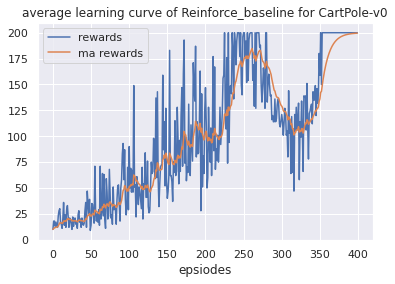

Episode:10/400: reward:200.0
Episode:20/400: reward:200.0
Episode:30/400: reward:200.0
Episode:40/400: reward:200.0
Episode:50/400: reward:200.0
Episode:60/400: reward:200.0
Episode:70/400: reward:200.0
Episode:80/400: reward:200.0
Episode:90/400: reward:200.0
Episode:100/400: reward:200.0
results saved!


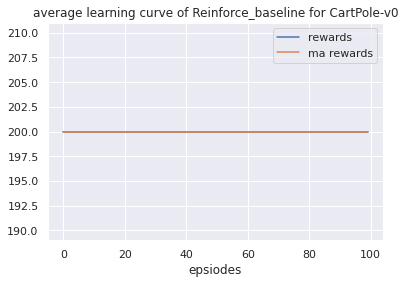

In [11]:
main()

Reinforce
Episode:10/400: reward:94.0
Episode:20/400: reward:24.0
Episode:30/400: reward:34.0
Episode:40/400: reward:24.0
Episode:50/400: reward:10.0
Episode:60/400: reward:31.0
Episode:70/400: reward:28.0
Episode:80/400: reward:41.0
Episode:90/400: reward:33.0
Episode:100/400: reward:33.0
Episode:110/400: reward:51.0
Episode:120/400: reward:46.0
Episode:130/400: reward:70.0
Episode:140/400: reward:69.0
Episode:150/400: reward:53.0
Episode:160/400: reward:159.0
Episode:170/400: reward:200.0
Episode:180/400: reward:45.0
Episode:190/400: reward:129.0
Episode:200/400: reward:145.0
Episode:210/400: reward:200.0
Episode:220/400: reward:200.0
Episode:230/400: reward:200.0
Episode:240/400: reward:200.0
Episode:250/400: reward:200.0
Episode:260/400: reward:200.0
Episode:270/400: reward:200.0
Episode:280/400: reward:200.0
Episode:290/400: reward:200.0
Episode:300/400: reward:200.0
Episode:310/400: reward:200.0
Episode:320/400: reward:200.0
Episode:330/400: reward:200.0
Episode:340/400: reward:2

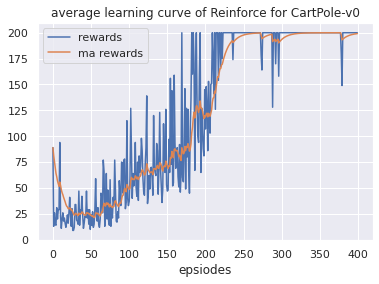

Episode:10/400: reward:200.0
Episode:20/400: reward:200.0
Episode:30/400: reward:200.0
Episode:40/400: reward:200.0
Episode:50/400: reward:200.0
Episode:60/400: reward:200.0
Episode:70/400: reward:200.0
Episode:80/400: reward:200.0
Episode:90/400: reward:200.0
Episode:100/400: reward:200.0
results saved!


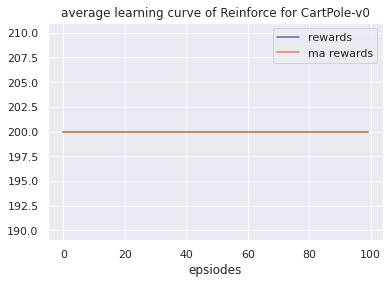

In [14]:
main()